In [37]:
from typing import List, Dict, Set, Tuple, Optional
import numpy as np
import cv2
import itertools
import random
import copy 
import matplotlib.pyplot as plt
from utils import Path
from tqdm import tqdm
import collections 

In [38]:
class FourOpt(Path):
    def __init__(self,
        image: np.ndarray,
        patch_size: Tuple[int,int],
        start: int,
        iteration: int = 1,
        verbose: Optional[bool] = True):
            
        super().__init__(image,patch_size,verbose)
        self.start = start
        self.iteration = iteration
        self.history = []

    def get_statistics(self):
        """
        Plot the statistics of 4-opt
        """
        self.history = np.asarray(self.history)
        plt.figure(figsize=(15,10))
        ax = plt.subplot(111)
        for i in range(self.iteration):
            ax.plot(np.arange(self.history.shape[1]),self.history[i,:],label=f"route {i}")

        box = ax.get_position()
        ax.set_position([box.x0, box.y0+box.height*0.1,box.width,box.height*0.9]) # shrink axis height by 10%
        ax.legend(loc="upper center", bbox_to_anchor=(0.5,-0.05),fancybox=True,shadow=True,ncol=self.iteration//2)
        ax.set_title("4 Opt")
        ax.set_ylabel("Distance")
        ax.set_xlabel("Iteration")
        plt.show()

    def initialize(self):
        route = [self.start]
        route += random.sample(range(1,self.num_vertex), self.num_vertex-1)

        duplicates = [item for item, count in collections.Counter(route).items() if count > 1]
        if len(duplicates) != 0:
            print(duplicates)
            
        assert len(duplicates) == 0, f"Initialize error"

        return route
    
    def get_distance(self,route):
        dist = 0
        for i in range(self.num_vertex-1):
            dist += self.weight_matrix[route[i],route[i+1]]

        return dist
    
    def four_exchange(self,route,case,a,c,e,g):
        """
        In this exchange we consider only pure non-sequential 4-opt moves which there are only 5 cases

        # TODO
        (1) Check for duplicates in 4-opt
        """
        b,d,f,h = a+1, c+1, e+1, g+1
        p_a, p_b, p_c, p_d, p_e, p_f, p_g, p_h = [route[i] for i in [a,b,c,d,e,f,g,h]]
        base = self.weight_matrix[p_a][p_b] + self.weight_matrix[p_c][p_d] + self.weight_matrix[p_e][p_f] + self.weight_matrix[p_g][p_h]

        # 2-opt cases
        if case == 1: #checked
            path = route[:a+1] + route[g:f-1:-1] + route[e:d-1:-1] + route[c:b-1:-1] + route[h:]
            cost = self.weight_matrix[p_a][p_g] + self.weight_matrix[p_f][p_e] + self.weight_matrix[p_d][p_c] + self.weight_matrix[p_b][p_h]

        if case == 2: #checked
            path = route[:a+1] + route[b:c+1] + route[d:e+1] + route[g:f-1:-1] + route[h:]
            cost = self.weight_matrix[p_a][p_b] + self.weight_matrix[p_c][p_d] + self.weight_matrix[p_e][p_g] + self.weight_matrix[p_f][p_h]

        if case == 3: #checked
            path = route[:a+1] + route[b:c+1] + route[e:d-1:-1] + route[f:g+1] + route[h:]
            cost = self.weight_matrix[p_a][p_b] + self.weight_matrix[p_c][p_e] + self.weight_matrix[p_d][p_f] + self.weight_matrix[p_g][p_h]

        if case == 4: #checked
            path = route[:a+1] + route[b:c+1] + route[g:f-1:-1] + route[e:d-1:-1] + route[h:]
            cost = self.weight_matrix[p_a][p_b] + self.weight_matrix[p_c][p_g] + self.weight_matrix[p_f][p_e] + self.weight_matrix[p_d][p_h]

        if case == 5: #checked
            path = route[:a+1] + route[e:d-1:-1] + route[c:b-1:-1] + route[f:g+1] + route[h:]
            cost = self.weight_matrix[p_a][p_e] + self.weight_matrix[p_d][p_c] + self.weight_matrix[p_b][p_f] + self.weight_matrix[p_g][p_h]

        if case == 6: #checked
            path = route[:a+1] + route[c:b-1:-1] + route[d:e+1] + route[f:g+1] + route[h:]
            cost = self.weight_matrix[p_a][p_c] + self.weight_matrix[p_b][p_d] + self.weight_matrix[p_e][p_f] + self.weight_matrix[p_g][p_h]

        # 3-opt cases
        if case == 7: #checked
            path = route[:a+1] + route[f:g+1] + route[e:d-1:-1] + route[c:b-1:-1] + route[h:]
            cost = self.weight_matrix[p_a][p_f] + self.weight_matrix[p_g][p_e] + self.weight_matrix[p_d][p_c] + self.weight_matrix[p_b][p_h]

        if case == 8: #checked
            path = route[:a+1] + route[b:c+1] + route[e:d-1:-1] + route[g:f-1:-1] + route[h:]
            cost = self.weight_matrix[p_a][p_b] + self.weight_matrix[p_c][p_e] + self.weight_matrix[p_d][p_g] + self.weight_matrix[p_f][p_h]

        if case == 9: #checked
            path = route[:a+1] + route[b:c+1] + route[f:g+1] + route[d:e+1] + route[h:]
            cost = self.weight_matrix[p_a][p_b] + self.weight_matrix[p_c][p_f] + self.weight_matrix[p_g][p_d] + self.weight_matrix[p_e][p_h]

        if case == 10: #checked
            path = route[:a+1] + route[b:c+1] + route[f:g+1] + route[e:d-1:-1] + route[h:]
            cost = self.weight_matrix[p_a][p_b] + self.weight_matrix[p_c][p_f] + self.weight_matrix[p_e][p_g] + self.weight_matrix[p_d][p_h]

        if case == 11: #checked
            path = route[:a+1] + route[b:c+1] + route[g:f-1:-1] + route[d:e+1] + route[h:]
            cost = self.weight_matrix[p_a][p_b] + self.weight_matrix[p_c][p_g] + self.weight_matrix[p_f][p_d] + self.weight_matrix[p_e][p_h]

        if case == 12: #checked
            path = route[:a+1] + route[d:e+1] + route[f:g+1] + route[c:b-1:-1] + route[h:]
            cost = self.weight_matrix[p_a][p_d] + self.weight_matrix[p_e][p_f] + self.weight_matrix[p_g][p_c] + self.weight_matrix[p_b][p_h]

        if case == 13: #checked
            path = route[:a+1] + route[d:e+1] + route[f:g+1] + route[b:c+1] + route[h:]
            cost = self.weight_matrix[p_a][p_d] + self.weight_matrix[p_e][p_f] + self.weight_matrix[p_g][p_b] + self.weight_matrix[p_c][p_h]

        if case == 14: #checked
            path = route[:a+1] + route[c:b-1:-1] + route[g:f-1:-1] + route[e:d-1:-1] + route[h:]
            cost = self.weight_matrix[p_a][p_c] + self.weight_matrix[p_b][p_g] + self.weight_matrix[p_f][p_e] + self.weight_matrix[p_d][p_h]

        if case == 15: #checked
            path = route[:a+1] + route[f:g+1] + route[b:c+1] + route[d:e+1] + route[h:]
            cost = self.weight_matrix[p_a][p_f] + self.weight_matrix[p_g][p_b] + self.weight_matrix[p_c][p_d] + self.weight_matrix[p_e][p_h]

        if case == 16: #checked
            path = route[:a+1] + route[g:f-1:-1] + route[b:c+1] + route[d:e+1] + route[h:]
            cost = self.weight_matrix[p_a][p_g] + self.weight_matrix[p_f][p_b] + self.weight_matrix[p_c][p_d] + self.weight_matrix[p_e][p_h]

        if case == 17: #checked
            path = route[:a+1] + route[e:d-1:-1] + route[c:b-1:-1] + route[g:f-1:-1] + route[h:]
            cost = self.weight_matrix[p_a][p_e] + self.weight_matrix[p_d][p_c] + self.weight_matrix[p_b][p_g] + self.weight_matrix[p_f][p_h]

        if case == 18: #checked
            path = route[:a+1] + route[d:e+1] + route[c:b-1:-1] + route[f:g+1] + route[h:]
            cost = self.weight_matrix[p_a][p_d] + self.weight_matrix[p_e][p_c] + self.weight_matrix[p_b][p_f] + self.weight_matrix[p_g][p_h]

        if case == 19: #checked
            path = route[:a+1] + route[d:e+1] + route[b:c+1] + route[f:g+1] + route[h:]
            cost = self.weight_matrix[p_a][p_d] + self.weight_matrix[p_e][p_b] + self.weight_matrix[p_c][p_f] + self.weight_matrix[p_g][p_h]

        if case == 20: #checked
            path = route[:a+1] + route[e:d-1:-1] + route[b:c+1] + route[f:g+1] + route[h:]
            cost = self.weight_matrix[p_a][p_e] + self.weight_matrix[p_d][p_b] + self.weight_matrix[p_f][p_c] + self.weight_matrix[p_g][p_h]

        if case == 21: #checked
            path = route[:a+1] + route[g:f-1:-1] + route[e:d-1:-1] + route[b:c+1] + route[h:]
            cost = self.weight_matrix[p_a][p_g] + self.weight_matrix[p_f][p_e] + self.weight_matrix[p_d][p_b] + self.weight_matrix[p_c][p_h]

        if case == 22: #checked
            path = route[:a+1] + route[c:b-1:-1] + route[e:d-1:-1] + route[f:g+1] + route[h:]
            cost = self.weight_matrix[p_a][p_c] + self.weight_matrix[p_b][p_e] + self.weight_matrix[p_f][p_d] + self.weight_matrix[p_g][p_h]

        # 4-opt cases
        if case == 23: #checked
            path = route[:a+1] + route[f:g+1] + route[d:e+1] + route[c:b-1:-1] + route[h:]
            cost = self.weight_matrix[p_a][p_f] + self.weight_matrix[p_g][p_d] + self.weight_matrix[p_e][p_c] + self.weight_matrix[p_b][p_h]

        if case == 24: #checked
            path = route[:a+1] + route[e:d-1:-1] + route[g:f-1:-1] + route[c:b-1:-1] + route[h:]
            cost = self.weight_matrix[p_a][p_e] + self.weight_matrix[p_g][p_d] + self.weight_matrix[p_f][p_c] + self.weight_matrix[p_b][p_h]

        if case == 25: #checked
            path = route[:a+1] + route[d:e+1] + route[g:f-1:-1] + route[c:b-1:-1] + route[h:]
            cost = self.weight_matrix[p_a][p_d] + self.weight_matrix[p_e][p_g] + self.weight_matrix[p_f][p_c] + self.weight_matrix[p_b][p_h]

        if case == 26: #checked
            path = route[:a+1] + route[e:d-1:-1] + route[f:g+1] + route[c:b-1:-1] + route[h:]
            cost = self.weight_matrix[p_a][p_e] + self.weight_matrix[p_d][p_f] + self.weight_matrix[p_c][p_g] + self.weight_matrix[p_b][p_h]

        if case == 27: #checked
            path = route[:a+1] + route[d:e+1] + route[g:f-1:-1] + route[b:c+1] + route[h:]
            cost = self.weight_matrix[p_a][p_d] + self.weight_matrix[p_g][p_e] + self.weight_matrix[p_f][p_b] + self.weight_matrix[p_c][p_h]

        if case == 28: #checked
            path = route[:a+1] + route[e:d-1:-1] + route[f:g+1] + route[b:c+1] + route[h:]
            cost = self.weight_matrix[p_a][p_e] + self.weight_matrix[p_f][p_d] + self.weight_matrix[p_g][p_b] + self.weight_matrix[p_c][p_h]

        if case == 29: #checked
            path = route[:a+1] + route[c:b-1:-1] + route[f:g+1] + route[e:d-1:-1] + route[h:]
            cost = self.weight_matrix[p_a][p_c] + self.weight_matrix[p_f][p_b] + self.weight_matrix[p_e][p_g] + self.weight_matrix[p_d][p_h]

        if case == 30: #checked
            path = route[:a+1] + route[c:b-1:-1] + route[g:f-1:-1] + route[d:e+1] + route[h:]
            cost = self.weight_matrix[p_a][p_c] + self.weight_matrix[p_g][p_b] + self.weight_matrix[p_f][p_d] + self.weight_matrix[p_e][p_h]

        if case == 31: #checked
            path = route[:a+1] + route[c:b-1:-1] + route[f:g+1] + route[d:e+1] + route[h:]
            cost = self.weight_matrix[p_a][p_c] + self.weight_matrix[p_b][p_f] + self.weight_matrix[p_g][p_d] + self.weight_matrix[p_e][p_h]

        if case == 32: #checked
            path = route[:a+1] + route[f:g+1] + route[b:c+1] + route[e:d-1:-1] + route[h:]
            cost = self.weight_matrix[p_a][p_f] + self.weight_matrix[p_g][p_b] + self.weight_matrix[p_e][p_c] + self.weight_matrix[p_d][p_h]

        if case == 33: #checked
            path = route[:a+1] + route[g:f-1:-1] + route[b:c+1] + route[e:d-1:-1] + route[h:]
            cost = self.weight_matrix[p_a][p_g] + self.weight_matrix[p_f][p_b] + self.weight_matrix[p_c][p_e] + self.weight_matrix[p_d][p_h]

        if case == 34: #checked
            path = route[:a+1] + route[d:e+1] + route[c:b-1:-1] + route[g:f-1:-1] + route[h:]
            cost = self.weight_matrix[p_a][p_d] + self.weight_matrix[p_e][p_c] + self.weight_matrix[p_b][p_g] + self.weight_matrix[p_f][p_h]
                
        if case == 35: #checked
            path = route[:a+1] + route[g:f-1:-1] + route[c:b-1:-1] + route[e:d-1:-1] + route[h:]
            cost = self.weight_matrix[p_a][p_g] + self.weight_matrix[p_f][p_c] + self.weight_matrix[p_e][p_b] + self.weight_matrix[p_d][p_h]

        if case == 36: #checked
            path = route[:a+1] + route[g:f-1:-1] + route[c:b-1:-1] + route[d:e+1] + route[h:]
            cost = self.weight_matrix[p_a][p_g] + self.weight_matrix[p_f][p_c] + self.weight_matrix[p_b][p_d] + self.weight_matrix[p_e][p_h]

        if case == 37: #checked
            path = route[:a+1] + route[d:e+1] + route[b:c+1] + route[g:f-1:-1] + route[h:]
            cost = self.weight_matrix[p_a][p_d] + self.weight_matrix[p_e][p_b] + self.weight_matrix[p_g][p_c] + self.weight_matrix[p_f][p_h]

        if case == 38: #checked
            path = route[:a+1] + route[e:d-1:-1] + route[b:c+1] + route[g:f-1:-1] + route[h:]
            cost = self.weight_matrix[p_a][p_e] + self.weight_matrix[p_b][p_d] + self.weight_matrix[p_g][p_c] + self.weight_matrix[p_f][p_h]

        if case == 39: #checked
            path = route[:a+1] + route[f:g+1] + route[c:b-1:-1] + route[d:e+1] + route[h:]
            cost = self.weight_matrix[p_a][p_f] + self.weight_matrix[p_g][p_c] + self.weight_matrix[p_b][p_d] + self.weight_matrix[p_e][p_h]

        if case == 40: #checked
            path = route[:a+1] + route[f:g+1] + route[e:d-1:-1] + route[b:c+1] + route[h:]
            cost = self.weight_matrix[p_a][p_f] + self.weight_matrix[p_g][p_e] + self.weight_matrix[p_d][p_b] + self.weight_matrix[p_c][p_h]
        
        if case == 41: #checked
            path = route[:a+1] + route[g:f-1:-1] + route[d:e+1] + route[b:c+1] + route[h:]
            cost = self.weight_matrix[p_a][p_g] + self.weight_matrix[p_f][p_d] + self.weight_matrix[p_e][p_b] + self.weight_matrix[p_c][p_h]
        
        if case == 42: #checked
            path = route[:a+1] + route[c:b-1:-1] + route[e:d-1:-1] + route[g:f-1:-1] + route[h:]
            cost = self.weight_matrix[p_a][p_c] + self.weight_matrix[p_b][p_e] + self.weight_matrix[p_d][p_g] + self.weight_matrix[p_f][p_h]
           
        if case == 43: #checked
            path = route[:a+1] + route[g:f-1:-1] + route[d:e+1] + route[c:b-1:-1] + route[h:]
            cost = self.weight_matrix[p_a][p_g] + self.weight_matrix[p_f][p_d] + self.weight_matrix[p_e][p_c] + self.weight_matrix[p_b][p_h]

        if case == 44: #checked 
            path = route[:a+1] + route[e:d-1:-1] + route[g:f-1:-1] + route[b:c+1] + route[h:]
            cost = self.weight_matrix[p_a][p_e] + self.weight_matrix[p_d][p_g] + self.weight_matrix[p_f][p_b] + self.weight_matrix[p_c][p_h]

        if case == 45: #checked
            path = route[:a+1] + route[f:g+1] + route[c:b-1:-1] + route[e:d-1:-1] + route[h:]
            cost = self.weight_matrix[p_a][p_f] + self.weight_matrix[p_g][p_c] + self.weight_matrix[p_b][p_e] + self.weight_matrix[p_d][p_h]

        if case == 46:
            path = route[:a+1] + route[f:g+1] + route[d:e+1] + route[b:c+1] + route[h:]
            cost = self.weight_matrix[p_a][p_f] + self.weight_matrix[p_g][p_d] + self.weight_matrix[p_e][p_b] + self.weight_matrix[p_c][p_h]

        if case == 47:
            path = route[:a+1] + route[c:b-1:-1] + route[d:e+1] + route[g:f-1:-1] + route[h:]
            cost = self.weight_matrix[p_a][p_c] + self.weight_matrix[p_b][p_d] + self.weight_matrix[p_e][p_g] + self.weight_matrix[p_f][p_h]


        duplicates = [item for item, count in collections.Counter(path).items() if count > 1]
        if len(duplicates) != 0:
            print(path)
            print(duplicates)

        assert len(duplicates) == 0, f"Case {case}: path change error"
        return path, base-cost
        

    def four_opt(self,route: List[int],num_iteration: Optional[int] = None):
        
        iteration = 0
        self.history.append(self.get_distance(route))
        for a in random.sample(range(self.num_vertex-7),self.num_vertex-7):
            for c in random.sample(range(a+2,len(route)-5),len(route)-a-7):
                for e in random.sample(list(range(c+2,len(route)-3)),len(route)-c-5):
                    for g in random.sample(list(range(e+2,len(route)-1)),len(route)-e-3):
                        temp_route = copy.deepcopy(route)
                        base_change = 0
                        for i in range(1,48):
                            path, change = self.four_exchange(temp_route,i,a,c,e,g)
                            if change > base_change:
                                route = path
                                base_change = change

                            iteration += 1

                            distance = self.get_distance(route)
                            self.history.append(distance)
                            if iteration % 10000 == 0:
                                print(f"Iteration {iteration} : Distance = {distance}")
                            
                            assert self.history[iteration-1] >= self.history[iteration], "Next step should be lower"

                            if iteration == num_iteration:
                                plt.figure()
                                plt.plot(range(len(self.history)),self.history)
                                plt.show()
                                return route
        
    def _optimize(self):
        best_route = self.initialize()
        best_route = self.build_path(best_route,self.adj_list,self.local_to_coords)
        for i in range(self.iteration):
            route = self.initialize()
            next_route = self.build_path(self.four_opt(route,1000000),self.adj_list,self.local_to_coords)
            if len(next_route) < len(best_route):
                best_route = next_route
            
        return self.build_path(best_route,self.adj_list,self.local_to_coords)



Preprocessing of graph completed
336
Iteration 10000 : Distance = 8317.0
Iteration 20000 : Distance = 5631.0
Iteration 30000 : Distance = 5427.0
Iteration 40000 : Distance = 5401.0
Iteration 50000 : Distance = 5401.0
Iteration 60000 : Distance = 5401.0
Iteration 70000 : Distance = 5391.0
Iteration 80000 : Distance = 5391.0
Iteration 90000 : Distance = 5391.0
Iteration 100000 : Distance = 5387.0
Iteration 110000 : Distance = 5383.0
Iteration 120000 : Distance = 5343.0
Iteration 130000 : Distance = 5339.0
Iteration 140000 : Distance = 5335.0
Iteration 150000 : Distance = 5329.0
Iteration 160000 : Distance = 5329.0
Iteration 170000 : Distance = 5303.0
Iteration 180000 : Distance = 5297.0
Iteration 190000 : Distance = 5271.0
Iteration 200000 : Distance = 5143.0
Iteration 210000 : Distance = 5009.0
Iteration 220000 : Distance = 5007.0
Iteration 230000 : Distance = 4993.0
Iteration 240000 : Distance = 4993.0
Iteration 250000 : Distance = 4917.0
Iteration 260000 : Distance = 4917.0
Iteration 

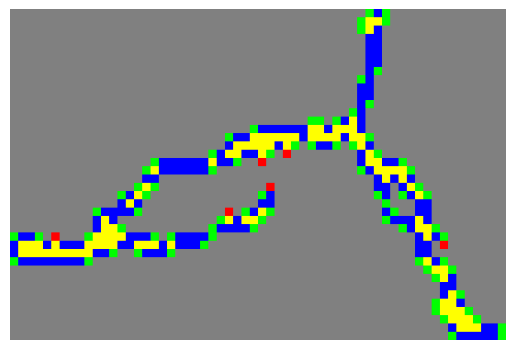

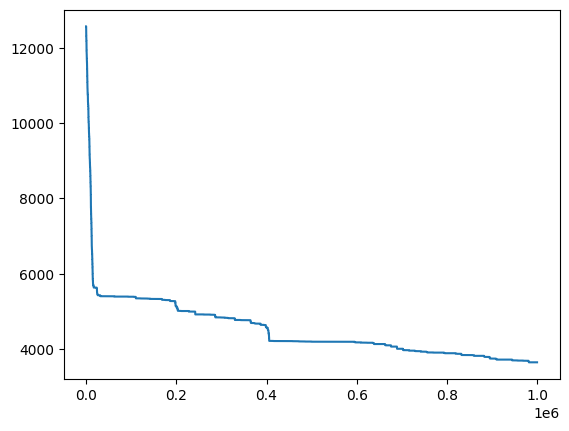

(3664, 3328, 0)


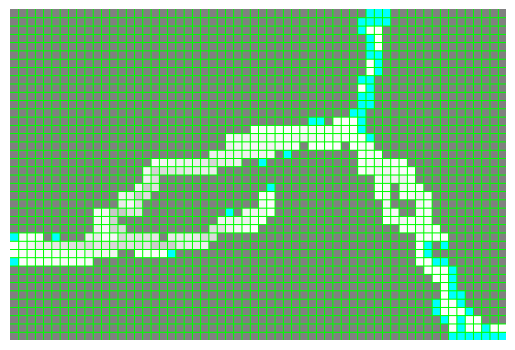

In [39]:
if __name__ == "__main__":

    img = cv2.imread("./binary_image/276.png",cv2.IMREAD_UNCHANGED) 
    ps = (8,8)
    x = FourOpt(img,ps,0,True)
    print(x.num_vertex)
    route = x._optimize()
    route = list(map(lambda node: x.mapping_r[node],route))
    
    print(x.path_checker(route))